https://deep-deep-deep.tistory.com/160

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format

# 한글 폰트 문제
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 모델 관련
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import plot_importance
from catboost import CatBoostClassifier

# 인코딩
from category_encoders import BinaryEncoder

In [2]:
df = pd.read_csv('./dataset/gmm_clustering.csv', encoding='utf-8')
df

,avg_score,num_usecard,monthly_card_spend,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,...,credit_card_installments_payment,monthly_spend,cluster,city,ages,sex,avg_rat,monthly_loan,credit_card_payment,debit_card_payment
0,740,1.99000,810000,18500000,620000,2110000,680000,1320000,3800000,10520000,...,83000,727000,2,서울,20대,NaN,4,24940000,254000,473000
1,782,1.75000,790000,24150000,680000,2300000,790000,1160000,5420000,12220000,...,83000,707000,2,서울,20대,NaN,4,30880000,278000,429000
2,782,1.74000,790000,24240000,680000,2300000,790000,1210000,5350000,12280000,...,78000,712000,2,서울,20대,NaN,4,31000000,267000,445000
3,782,1.75000,860000,24570000,680000,2300000,790000,1230000,5380000,12320000,...,89000,771000,2,서울,20대,NaN,4,31390000,292000,479000
4,781,1.75000,820000,24830000,700000,2320000,770000,1250000,5430000,12420000,...,82000,738000,2,서울,20대,NaN,4,31730000,285000,453000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,818,0.18000,200000,58460000,230000,260000,1610000,290000,8600000,18710000,...,43000,157000,0,NaN,80대,여자,3,69610000,82000,75000
3020,818,0.18000,190000,58330000,230000,270000,1610000,310000,8550000,18750000,...,39000,151000,0,NaN,80대,여자,3,69500000,82000,69000
3021,818,0.18000,210000,58190000,240000,290000,1610000,430000,8630000,18760000,...,49000,161000,0,NaN,80대,여자,3,69510000,87000,74000
3022,819,0.18000,200000,58420000,240000,300000,1610000,470000,8570000,18690000,...,44000,156000,0,NaN,80대,여자,3,69750000,80000,76000


In [3]:
df_encoding = df[['monthly_spend', 'avg_score', 'cluster', 'city', 'ages']]
df_encoding['city'] = df_encoding['city'].fillna('없음')

In [4]:
df_encoding.city.unique()

array(['서울', '인천', '대전', '대구', '광주', '부산', '울산', '경기', '강원', '충북', '충남',
       '전북', '전남', '경북', '경남', '제주', '없음'], dtype=object)

In [5]:
# 바이너리 인코딩(Binary Encoding) - 도시, 나이
enc_city = BinaryEncoder(cols='city')
enc_age = BinaryEncoder(cols='ages')
df_encoding = enc_city.fit_transform(df_encoding)
df_encoding = enc_age.fit_transform(df_encoding)

In [6]:
df_encoding.drop(['city_0', 'ages_0'], axis=1, inplace=True)

In [7]:
# city, age 붙여넣기
df_encoding = pd.concat([df_encoding, df[['city', 'ages']]], axis=1)
df_encoding['city'] = df_encoding['city'].fillna('없음')
df_encoding.head()

,monthly_spend,avg_score,cluster,city_1,city_2,city_3,city_4,city_5,ages_1,ages_2,ages_3,city,ages
0,727000,740,2,0,0,0,0,1,0,0,1,서울,20대
1,707000,782,2,0,0,0,0,1,0,0,1,서울,20대
2,712000,782,2,0,0,0,0,1,0,0,1,서울,20대
3,771000,782,2,0,0,0,0,1,0,0,1,서울,20대
4,738000,781,2,0,0,0,0,1,0,0,1,서울,20대


In [8]:
# dataframe 컬럼 순서 변경
df_encoding = df_encoding[['monthly_spend', 'avg_score', 'city_1', 'city_2',
       'city_3', 'city_4', 'city_5', 'ages_1', 'ages_2', 'ages_3',
       'city', 'ages', 'cluster']]

In [9]:
city_encoding = df_encoding[['city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city']].drop_duplicates().reset_index(drop=True)
ages_encoding = df_encoding[['ages_1', 'ages_2', 'ages_3', 'ages']].drop_duplicates().reset_index(drop=True)

In [10]:
city_encoding.to_csv('./dataset/city_encoding.csv', encoding='utf-8', index=False)
ages_encoding.to_csv('./dataset/ages_encoding.csv', encoding='utf-8', index=False)

#### XGBoost

In [11]:
df_xgb = df_encoding.copy()
df_xgb.head()

,monthly_spend,avg_score,city_1,city_2,city_3,city_4,city_5,ages_1,ages_2,ages_3,city,ages,cluster
0,727000,740,0,0,0,0,1,0,0,1,서울,20대,2
1,707000,782,0,0,0,0,1,0,0,1,서울,20대,2
2,712000,782,0,0,0,0,1,0,0,1,서울,20대,2
3,771000,782,0,0,0,0,1,0,0,1,서울,20대,2
4,738000,781,0,0,0,0,1,0,0,1,서울,20대,2


In [12]:
# 피쳐와 라벨 분류
X_features = df_xgb.iloc[:, :-3]
y_labels = df_xgb.iloc[:, -1]

# train, test 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=121)
print(X_train.shape, X_test.shape)

(2419, 10) (605, 10)


In [13]:
xgb = XGBClassifier()
param_grid_xgb={'booster' :['gbtree'],
                 'silent':[1],
                 'max_depth':[5,6],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators' : [300, 500],
                 'objective':['multi:softmax'],
                 'learning_rate' : [0.05, 0.1],
                 'random_state':[121],
                 'subsample' : [0.7, 1.0],
                 'eval_metric':['mlogloss', 'merror']}

In [14]:
kf = StratifiedKFold(n_splits=5, random_state=121, shuffle=True)

gcv_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv = kf, scoring='f1_macro', n_jobs=4, refit = True, return_train_score = True)
gcv_xgb.fit(X_train, y_train)

# 각 파라미터값들에 대한 모델 결과값들이 cv_results_ 객체에 할당됨
scores_xgb_df = pd.DataFrame(gcv_xgb.cv_results_)

[23:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [15]:
# 최적의 파라미터는 best_params_에 할당되어있음
print(f"최적의 파라미터 : {gcv_xgb.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {gcv_xgb.best_score_}")

최적의 파라미터 : {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'objective': 'multi:softmax', 'random_state': 121, 'silent': 1, 'subsample': 1.0}
최적의 파라미터로 모델의 정확도 : 0.9916460343338345


In [16]:
# 최적의 파라미터로 학습되어 있는 모델링 할당
estimator_xgb = gcv_xgb.best_estimator_

In [17]:
# 최적의 모델로 예측해보고 실제값이랑 정확도 비교
pred_xgb = estimator_xgb.predict(X_test)
print(f"실제값과 예측값 정확도 : {accuracy_score(y_test, pred_xgb)}")
print("macro 평균 f1 점수 : {:.3f}".format(f1_score(y_test,pred_xgb,average = "macro")))

실제값과 예측값 정확도 : 0.9950413223140496
macro 평균 f1 점수 : 0.995


In [18]:
# 나이 -> 20대, monthly_spend, avg_score -> cluster 5 중앙값
test = pd.DataFrame([[1375000, 804, 0, 0, 0, 0, 1, 0, 0, 1]] )
test

,0,1,2,3,4,5,6,7,8,9
0,1375000,804,0,0,0,0,1,0,0,1


In [19]:
pred_test = estimator_xgb.predict(test)
pred_test

array([5])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

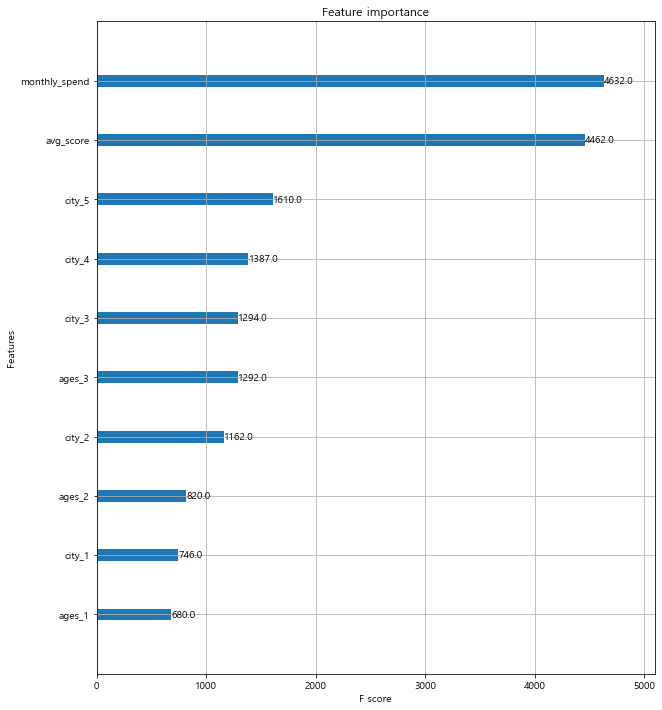

In [20]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(estimator_xgb, ax=ax)

---

#### LightGBM

LightGBM과 XGBoost를 비교했을 때의 장점
- 빠른 학습 및 예측 수행 시간
- 더 작은 메모리 사용량
- 카테코리형 피처의 자동 변환 및 최적 분할

그러나, 10,000건 이하의 데이터셋에 대해 과적합 문제 발생하기 쉽다는 단점

In [21]:
df_lgbm = df_encoding.copy()
df_lgbm.head()

,monthly_spend,avg_score,city_1,city_2,city_3,city_4,city_5,ages_1,ages_2,ages_3,city,ages,cluster
0,727000,740,0,0,0,0,1,0,0,1,서울,20대,2
1,707000,782,0,0,0,0,1,0,0,1,서울,20대,2
2,712000,782,0,0,0,0,1,0,0,1,서울,20대,2
3,771000,782,0,0,0,0,1,0,0,1,서울,20대,2
4,738000,781,0,0,0,0,1,0,0,1,서울,20대,2


In [22]:
# 피쳐와 라벨 분류
X_features = df_lgbm.iloc[:, :-3]
y_labels = df_lgbm.iloc[:, -1]

# train, test 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=121)
print(X_train.shape, X_test.shape)

(2419, 10) (605, 10)


In [23]:
lgbm = LGBMClassifier()
param_grid_lgbm={'boosting_type' :['gbdt'], # 부스팅 방법 rf, gbdt(디폴트), dart, goos
                 'silent':[True],
                 'max_depth':[4, 5],
                 'min_child_weight':[3,5],
                 #'gamma':[0,1],
                 'nthread':[4],
                 'colsample_bytree':[0.7,0.8],
                 #'colsample_bylevel':[0.9],
                 'objective':['multiclass'],
                 'random_state':[121],
                 'learning_rate' : [0.05, 0.1],
                 'n_estimators' : [300, 500],
                 'subsample' : [0.7, 1.0],
                 'metric':['multi_logloss', 'multi_error']}

In [24]:
kf = StratifiedKFold(n_splits=5, random_state=121, shuffle=True)

gcv_lgbm = GridSearchCV(lgbm, param_grid=param_grid_lgbm, cv = kf, scoring='f1_macro', n_jobs=4, refit = True, return_train_score = True)
gcv_lgbm.fit(X_train, y_train)

# 각 파라미터값들에 대한 모델 결과값들이 cv_results_ 객체에 할당됨
scores_df_lgbm = pd.DataFrame(gcv_lgbm.cv_results_)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


In [25]:
# 최적의 파라미터는 best_params_에 할당되어있음
print(f"최적의 파라미터 : {gcv_lgbm.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {gcv_lgbm.best_score_}")

최적의 파라미터 : {'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'multi_logloss', 'min_child_weight': 3, 'n_estimators': 300, 'nthread': 4, 'objective': 'multiclass', 'random_state': 121, 'silent': True, 'subsample': 0.7}
최적의 파라미터로 모델의 정확도 : 0.9906480129441059


In [26]:
# 최적의 파라미터로 학습되어 있는 모델링 할당
estimator_lgbm = gcv_lgbm.best_estimator_

In [27]:
# 최적의 모델로 예측해보고 실제값이랑 정확도 비교
pred_lgbm = estimator_lgbm.predict(X_test)
print(f"실제값과 예측값 정확도 : {accuracy_score(y_test, pred_lgbm)}")
print("macro 평균 f1 점수 : {:.3f}".format(f1_score(y_test,pred_lgbm,average = "macro")))

실제값과 예측값 정확도 : 0.9884297520661157
macro 평균 f1 점수 : 0.988


In [28]:
# 나이 -> 20대, monthly_spend, avg_score -> cluster 5 중앙값
test = pd.DataFrame([[1375000, 804, 0, 0, 0, 0, 1, 0, 0, 1]] )
test

,0,1,2,3,4,5,6,7,8,9
0,1375000,804,0,0,0,0,1,0,0,1


In [29]:
# 최적의 모델로 예측해보고 실제값이랑 정확도 비교
pred_test = estimator_lgbm.predict(test)
pred_test

array([5], dtype=int64)

Text(0.5, 1.0, 'Feature Importance')

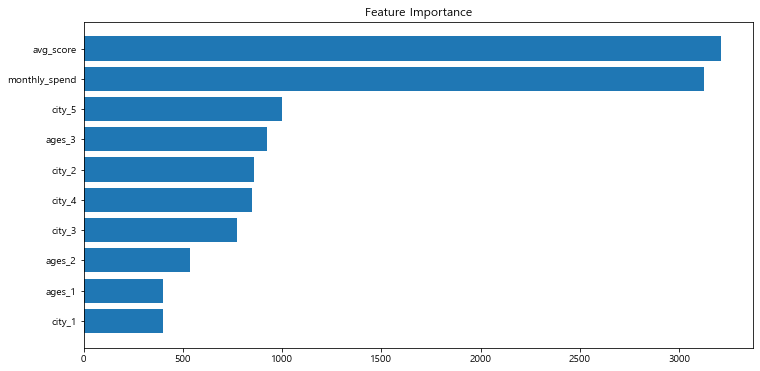

In [30]:
feature_importance = estimator_lgbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

----

#### Catboost

파라미터들이 최적화가 잘 되어있어서 튜닝에 크게 신경쓰지 않아도 됨

In [31]:
df_cb = df.copy()
df_cb = df_cb[['monthly_spend', 'avg_score', 'city', 'ages', 'cluster']]
df_cb.head()

,monthly_spend,avg_score,city,ages,cluster
0,727000,740,서울,20대,2
1,707000,782,서울,20대,2
2,712000,782,서울,20대,2
3,771000,782,서울,20대,2
4,738000,781,서울,20대,2


In [32]:
df_cb.city.fillna('없음', inplace=True)

In [33]:
# 피쳐와 라벨 분류
X_features = df_cb.iloc[:, :-1]
y_labels = df_cb.iloc[:, -1]

# train, test 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=121)

In [34]:
param_grid_cb = {'iterations':[100, 500],
          'depth': [4, 5, 6, 7],
          'learning_rate':[0.05, 0.1],
          'logging_level' : ['Silent'],
          'l2_leaf_reg': [5]}

cb = CatBoostClassifier(loss_function='MultiClass', random_seed=121)

In [35]:
kf = StratifiedKFold(n_splits=5, random_state=121, shuffle=True)

gcv_cb = GridSearchCV(cb, param_grid=param_grid_cb, cv = kf, scoring='f1_macro', n_jobs=4, refit = True, return_train_score = True)

gcv_cb.fit(X_train, y_train, cat_features=['city', 'ages'])

# 각 파라미터값들에 대한 모델 결과값들이 cv_results_ 객체에 할당됨
scores_df_cb = pd.DataFrame(gcv_cb.cv_results_)

In [36]:
# 최적의 파라미터는 best_params_에 할당되어있음
print(f"최적의 파라미터 : {gcv_cb.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {gcv_cb.best_score_}")

최적의 파라미터 : {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'logging_level': 'Silent'}
최적의 파라미터로 모델의 정확도 : 0.9971856906198194


In [37]:
# 최적의 파라미터로 학습되어 있는 모델링 할당
estimator_cb = gcv_cb.best_estimator_

In [38]:
# 최적의 모델로 예측해보고 실제값이랑 정확도 비교
pred_cb = estimator_cb.predict(X_test)
print(f"실제값과 예측값 정확도 : {accuracy_score(y_test, pred_cb)}")
print("macro 평균 f1 점수 : {:.3f}".format(f1_score(y_test,pred_cb,average = "macro")))

실제값과 예측값 정확도 : 0.9950413223140496
macro 평균 f1 점수 : 0.995


In [39]:
# 나이 -> 20대, monthly_spend, avg_score -> cluster 5 중앙값
test = [1375000, 804, '서울', '20대']
test

[1375000, 804, '서울', '20대']

In [40]:
# 최적의 모델로 예측해보고 실제값이랑 정확도 비교
pred_test = estimator_cb.predict(test)
pred_test

array([2], dtype=int64)

Text(0.5, 1.0, 'Feature Importance')

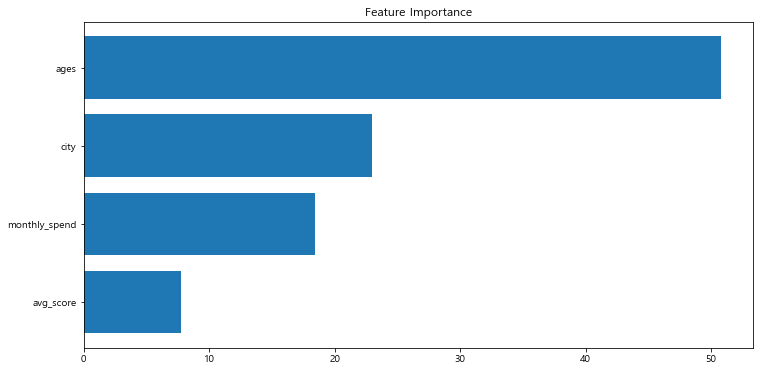

In [41]:
feature_importance = estimator_cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

XGBoost와 CatBoost가 accuracy, f1 score 모두 0.995 정도로 성능은 비슷

나이는 20대지만, 나머지 모두 cluster 5의 모습을 보이는 test 값(특수한 경우)에 대해

XGBoost는 cluster 5로, CatBoost는 cluster 2로 분류

test가 cluster5로 분류되었으면 좋겠음

-> XGBoost를 최종 모델로 선정

#### 모델 저장

In [42]:
# 모델 저장
estimator_xgb.save_model('xgb_model.model')

In [43]:
new_xgb_model = XGBClassifier() # 모델 초기화
new_xgb_model.load_model('xgb_model.model') # 모델 불러오기